In [1]:
import pandas as pd
import re

data_dir = "/workspace/chipper_data/chipper-svm-rfe/"

iedb_swiss_df = pd.DataFrame.from_csv(data_dir + "merged_iedb_swiss.csv")

saxova_df = pd.DataFrame.from_csv(data_dir + "saxova_in_vivo_mhc_1_ligands_dataset.csv")
saxova_df = saxova_df[["Sequences", "Activity"]]
saxova_df.columns = ["sequence", "is_cleaved"]
saxova_df.is_cleaved[saxova_df.is_cleaved == -1] = 0

print "There are %d training samples before removing the Saxova sequences." % (
    iedb_swiss_df.shape[0])
regex = re.compile("|".join(saxova_df.sequence))
iedb_swiss_df = iedb_swiss_df[iedb_swiss_df.protein_sequence.str.contains(regex) == False]
print "There are %d training samples after filtering out Saxova." % (
    iedb_swiss_df.shape[0])

There are 35848 training samples before removing the Saxova sequences.
There are 35181 training samples after filtering out Saxova.


In [2]:
# Converts the merged IEDB/Swiss-Prot table into training data
def create_training_set(iedb_swiss_merged, generated_sample_len):
    data = []
    for (protein_id,
         row_ids) in iedb_swiss_merged.groupby("protein_id").groups.items():
        epitope_rows = iedb_swiss_merged.loc[row_ids]
        # Grab the protein sequence from the first row
        protein_sequence = epitope_rows['protein_sequence'].iloc[0]
        # Sort by the C-terminus ('end')
        sorted_epitopes = epitope_rows.sort_values(by="end")
        protein_sequence_len = len(protein_sequence)
        current_loc = 0
        for (i, epitope_sequence, start, end) in \
                sorted_epitopes[["epitope_sequence", "start", "end"]].itertuples():
            epitope_start = int(start) - 1
            epitope_end = int(end) - 1

            half_sample_len = generated_sample_len / 2
            sample_start_end = lambda pos: (pos - half_sample_len + 1, pos + half_sample_len + 1)
            
            epitope_sequence_len = len(epitope_sequence)
            epitope_midpoint = epitope_end - epitope_sequence_len / 2
            
            cleaved_sample_pos = sample_start_end(epitope_end)
            uncleaved_sample_pos = sample_start_end(epitope_midpoint)
            
            # Check if our samples are off the protein sequence or overlap (TODO: handle these)
            if (uncleaved_sample_pos[0] < current_loc or
                    cleaved_sample_pos[1] > protein_sequence_len):
                continue

            current_loc = cleaved_sample_pos[1]

            # Double check that the start and end positions are correct
            assert protein_sequence[epitope_start:epitope_end + 1] == epitope_sequence,\
                     "Epitope failed to align to protein"

            fetch_seq = lambda pos: protein_sequence[pos[0]:pos[1]]
            data.append((fetch_seq(cleaved_sample_pos), 1))
            data.append((fetch_seq(uncleaved_sample_pos), 0))
                        
    cleavage_data = pd.DataFrame(data)
    cleavage_data.columns = ['sequence', 'is_cleaved']
    return cleavage_data

raw_training_data = create_training_set(iedb_swiss_df, 28)

In [3]:
raw_testing_data = saxova_df

In [4]:
from aa_props import seq_to_aa_props
from sklearn.preprocessing import MinMaxScaler


generated_sample_len = 28

# Filter to check for selenocysteine (TODO) and an invalid "'"
train_seq_validator = lambda seq: seq.find("U") == -1 and seq.find("'") == -1
# Testing set has two sample which are not the correct len, filter them out too
test_seq_validator = lambda seq: train_seq_validator(seq) and len(seq) == generated_sample_len

process_raw_data = lambda data, is_valid: [(seq_to_aa_props(seq), is_cleaved)
             for (i, seq, is_cleaved) in data.itertuples()
             if is_valid(seq)]

# Filter AA seqs and expand to AA features
training_X_y = process_raw_data(raw_training_data, train_seq_validator)
testing_X_y = process_raw_data(raw_testing_data, test_seq_validator)

(training_X, training_y) = zip(*training_X_y)
(testing_X, testing_y) = zip(*testing_X_y)

# Scale the data
scaler = MinMaxScaler()
training_X = scaler.fit_transform(training_X)
testing_X = scaler.transform(testing_X)

print "Final training set has %d samples of %d raw samples." % (
    training_X.shape[0], raw_training_data.shape[0])
print "Final testing set has %d samples of %d raw samples." % (
    testing_X.shape[0], raw_testing_data.shape[0])

Final training set has 48679 samples of 48682 raw samples.
Final testing set has 416 samples of 419 raw samples.


Fitting estimator with 1400 features.
Fitting estimator with 1400 features.
Fitting estimator with 1400 features.
Fitting estimator with 1400 features.
Fitting estimator with 1400 features.
Fitting estimator with 1330 features.
Fitting estimator with 1330 features.
Fitting estimator with 1330 features.
Fitting estimator with 1330 features.
Fitting estimator with 1330 features.
Fitting estimator with 1260 features.
Fitting estimator with 1260 features.
Fitting estimator with 1260 features.
Fitting estimator with 1260 features.
Fitting estimator with 1260 features.
Fitting estimator with 1190 features.
Fitting estimator with 1190 features.
Fitting estimator with 1190 features.
Fitting estimator with 1190 features.
Fitting estimator with 1190 features.
Fitting estimator with 1120 features.
Fitting estimator with 1120 features.
Fitting estimator with 1120 features.
Fitting estimator with 1120 features.
Fitting estimator with 1050 features.
Fitting estimator with 1050 features.
Fitting esti

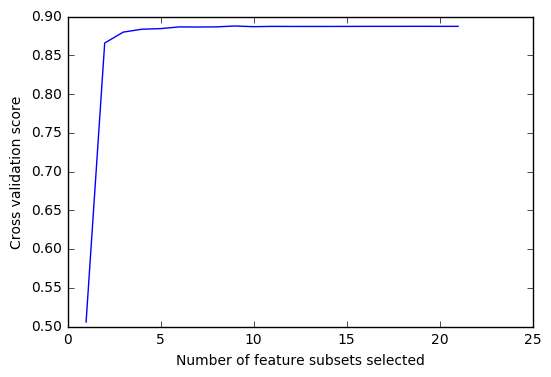

In [5]:
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFECV

svc = LinearSVC(C=0.0625)
rfe = RFECV(estimator=svc, step=.05, cv=5, scoring='accuracy', n_jobs=8, verbose=1)
rfe.fit(training_X, training_y)

print("Optimal number of features : %d" % rfe.n_features_)
print("Recursive Feature Elimination (RFE) eliminated %d features" % (training_X.shape[1] - rfe.n_features_))

%matplotlib inline
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of feature subsets selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

None


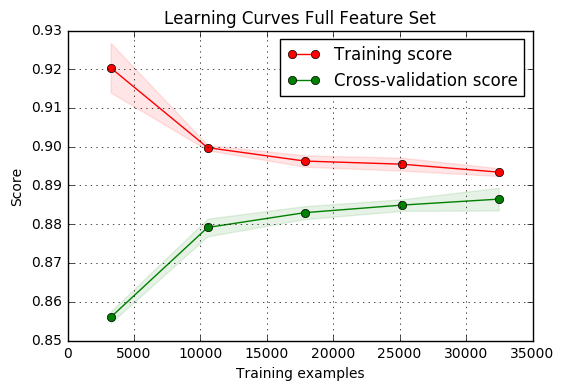

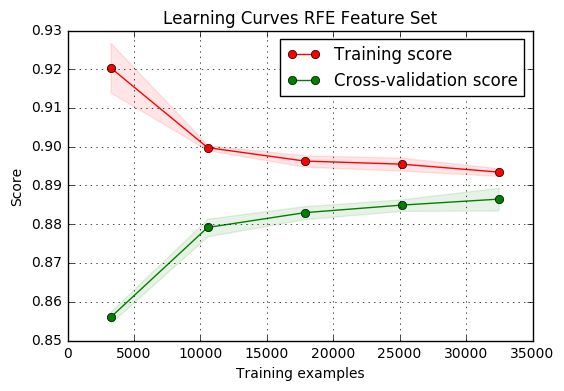

In [6]:
%matplotlib inline
from learning_curves import plot_learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit

#def create_learning_curve(title, model):
#    cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=7)
#    plot_learning_curve(model, title, training_X, training_y, (0.2, 1.01), cv=cv, n_jobs=1)

plot_learning_curve(svc, "Learning Curves Full Feature Set", training_X, training_y)
plot_learning_curve(rfe, "Learning Curves RFE Feature Set", training_X, training_y)

plt.show()

In [7]:
min_pos = -1
max_pos = -1
for (i, is_support) in enumerate(rfe.support_):
    if is_support:
        max_pos = i/50
        if min_pos == -1:
            min_pos = i/50
print (min_pos, max_pos)
        

(0, 27)


In [8]:
#from sklearn.svm import LinearSVC
#from sklearn.feature_selection import RFECV
#from sklearn.model_selection import GridSearchCV

#parameters={'estimator__C': [pow(2, i) for i in xrange(-25, 4, 1)]}
#svc = LinearSVC()
#rfe = RFECV(estimator=svc, step=.1, cv=5, scoring='accuracy', n_jobs=1)
#clf = GridSearchCV(rfe, parameters, scoring='accuracy', n_jobs=6, cv=5, verbose=1)
#clf.fit(training_X, training_y)

# summarize results
#print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
#means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#params = clf.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))